# Integration with VAMP+CYC model

This tutorial shows how data with substantial batch effects can be integrated with our model of choice - VAMP+CYC.

In [15]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from cross_system_integration.model._xxjointmodel import XXJointModel

## Prepare data for integration

Integration should be performed on normalized and log-transformed data, which is in our case stored in X. We recomend that data should be subsetted to HVGs before integration (already done for the example data), in accordance to the current best practices.

For integration we need the system covariate representing the covariate capturing the substantial batch effects, such as multiple species, primary tissue-organoid, or different sequencing technologies. Currently our model supports only exactly two systems. Besides system covariate any other (relatively weaker) batch effects of continous or categorical nature can be corrected for, such as the sample batch in the below example.

In [16]:
adata=sc.read('data/mouse-human_pancreas_subset10000.h5ad')

In [17]:
# Setup adata
adata = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    categorical_covariate_keys=['batch'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


## Train the model

We suggest that the VAMP+CYC model is used, as specified based on the prior and loss weights choice below.

The number of epochs can be reduced when using a dataset with more cells. Please inspect the loss plots below to confirm that the number of epochs is sufficient for the loss to stabilise. 

To increase the integration strength the `z_distance_cycle_weight` can be increased.

In [33]:
# Initialise the model
model = XXJointModel(
    adata=adata,
    prior='vamp', 
    n_prior_components=5,
    encode_pseudoinputs_on_eval_mode=True,
    z_dist_metric = 'MSE_standard',
)
# Train
max_epochs=200
model.train(
    max_epochs=max_epochs,
    # Parameters used for checking losses
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0, 
    # Loss weights
    plan_kwargs={
        'loss_weights':{
           'kl_weight':1.0,
           'kl_cycle_weight':0.0,
           'reconstruction_weight':1.0,
           'reconstruction_mixup_weight':0.0,
           'reconstruction_cycle_weight':0.0,
           'z_distance_cycle_weight':2.0,
           'translation_corr_weight':0.0,
           'z_contrastive_weight':0.0,

   }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [07:47<00:00,  2.34s/it, loss=-1.5e+03, v_num=1] 


### Inspect losses to assess if training was succesful

Training loss is plotted in blue and validation loss (held out random cells) in orange. The two losses will be similar due to the cells being randomly sampled into training/validation set without any stratification that would create trully distinct training/validation cell populations.

The top row shows whole training history while the botom row shows a zoom-in into only the epochs at the end of the training.

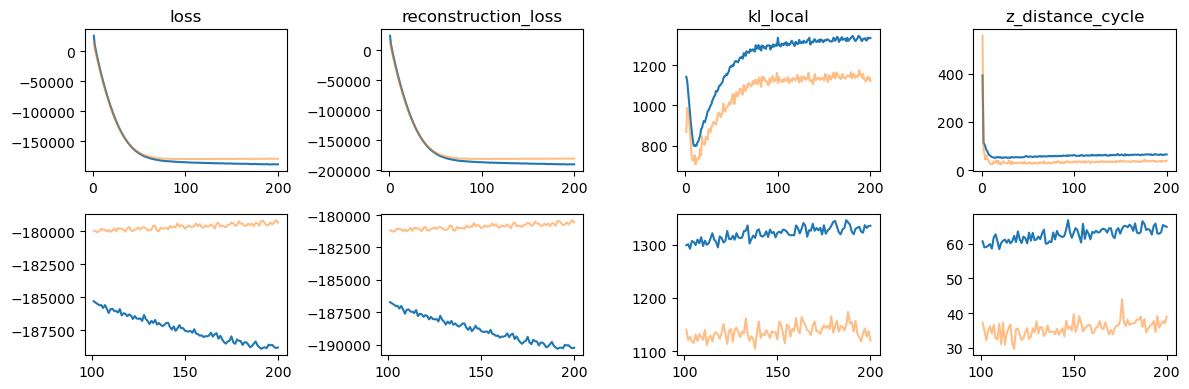

In [34]:
# Plot loses

# Make detailed plot after N epochs
epochs_detail_plot=100
steps_detail_plot = epochs_detail_plot*int(
    model.trainer.logger.history['loss_validation'].shape[0]/max_epochs)
detail_plot=epochs_detail_plot

# Loss plotting adapted to the above specified model and its training

# Losses to plot
# Set to plot only loses which we specified to be used for training above
losses=[
     'loss_train',
     'reconstruction_loss_train',
     'kl_local_train',
     'z_distance_cycle_train']
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for val leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently this works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,epochs_detail_plot),
        (l_val_values,'tab:orange',0.5, detail_plot)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

## Integrated embedding

Below we show how to obtain the integrated embedding and visually asssess cell type preservation and system integration.

In [35]:
# Get embedidng - save it into X of new adata
embed= model.embed(adata=adata)
embed=sc.AnnData(embed,obs=adata.obs)
# Make system categorical for plotting below
embed.obs['system']=embed.obs['system'].map({0:'mouse',1:'human'})

Plot the integrated embedding

In [36]:
# UMAP
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


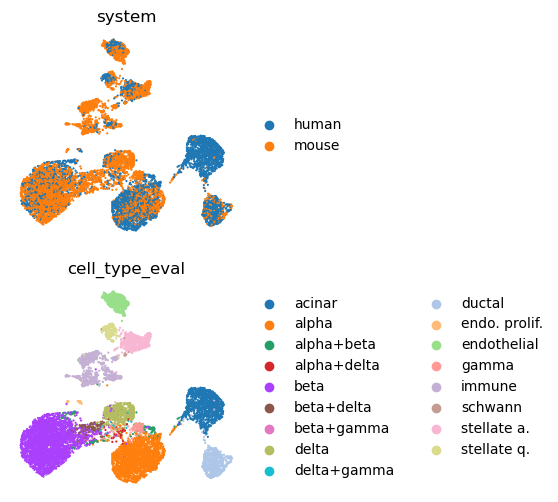

In [52]:
# Plot embedding UMAP
cols=['system','cell_type_eval']
fig,axs=plt.subplots(len(cols),1,figsize=(3,3*len(cols)))
for col,ax in zip(cols,axs):
    sc.pl.embedding(embed,'X_umap',color=col,s=10,ax=ax,show=False,sort_order=False,frameon=False)

Localisation of cell types from individual systems on integrated UMAP

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


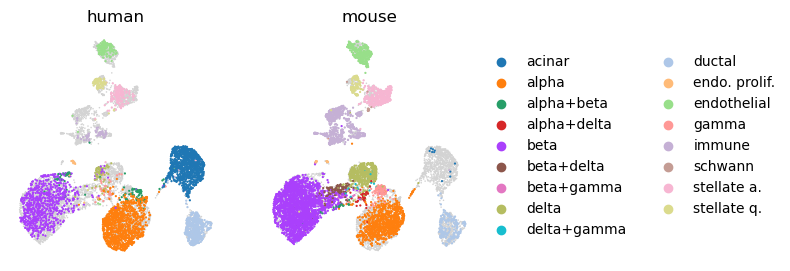

In [63]:
systems=sorted(embed.obs.system.unique())
ncols=len(systems)
fig,axs=plt.subplots(1,ncols,figsize=(3*ncols,3))
for i,system in enumerate(systems):
    ax=axs[i]
    sc.pl.umap(embed, ax=ax,show=False,s=5,frameon=False)
    sc.pl.umap(embed[embed.obs.system==system,:],color='cell_type_eval',
               ax=ax,show=False,s=10,frameon=False,title=system)
    if i!=ncols-1:
        ax.get_legend().remove()